<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw12/nn_hw12_eli5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## _[NN HW12](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/08-interp/Eli5%20text.ipynb)_

> В модель [по оценке популярности статьи на хабре](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw12/nn_hw12_fasttext_model.ipynb "nn_hw12_fasttext_model.ipynb") добавляем стоп-слова, которые сможете найти [по анализу ошибок](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/08-interp/Eli5%20text.ipynb "Eli5 text.ipynb").

> Есть два варианта. Первый - разбить на бины и решать задачу классификации (тогда будет TextExplainer) . Второй - использовать веса признаков явно (пример второго подхода можно посмотреть тут - https://www.kaggle.com/lopuhin/eli5-for-mercari)

---
К сожалению, предложенный вариант **#2** в данном случае не применим, поскольку [ELI5](https://eli5.readthedocs.io/en/latest/index.html "Welcome to ELI5’s documentation! &mdash; ELI5 documentation") в нынешнем виде поддерживает ограниченное число моделей на базе [конкретных библиотек](https://eli5.readthedocs.io/en/latest/libraries/index.html "Supported Libraries &mdash; ELI5 documentation") машинного обучения. Поэтому применить [`eli5.show_prediction`](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_prediction "ELI5 top-level API &mdash; ELI5 documentation") напрямую к прозвольной модели на основе нейросети, судя по всему, не получится (по крайней мере, я не нашёл способа, как это можно было бы сделать).

В то же время ELI5 предлагает следующую возможность: [Inspecting Black-Box Estimators](https://eli5.readthedocs.io/en/latest/blackbox/index.html "Inspecting Black-Box Estimators &mdash; ELI5 documentation"). В частности, реализацию метода [LIME](https://eli5.readthedocs.io/en/latest/blackbox/lime.html "LIME &mdash; ELI5 documentation"). Но он подходит только для моделей классификации.

Так что попробуем трансформировать исходную задачу регрессии в задачу классификации.

Итак, план примерно такой:

1. Заменить задачу регрессии на задачу классификации. Для этого:
    1.   Дискретизировать значение целевой переменной на выбранное число интервалов, которые и станут классами.
    2.   Заменить последний слой обученной модели регрессии на слой с активацией `softmax` и обучить его.
2.   Посмотреть интерпретацию ELI5 для решённой теперь уже задачи классификации на отдельном тексте (например, который был лучше / хуже всего классифицирован).

Тексты после препроцессинга (удаление `HTML` тегов) были сохранены заранее, потому что, очевидно, для интерпретации ELI5 нам нужен именно текст. Поэтому токенизацию и паддинг придётся повторить, поскольку модель, естественно, принимает на вход последовательности чисел одинаковой длины.

In [0]:
!pip search eli5 | grep INSTALLED || pip install eli5

  INSTALLED: 0.8.2 (latest)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np

import pickle
import warnings

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [0]:
import tensorflow as tf

from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
print(tf.__version__)
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

1.14.0-rc1


In [0]:
import eli5
from eli5.lime import TextExplainer

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%%bash

ls -lh *.{h5,npy}

-rw-r--r-- 1 root root 1.2G Jun 25 09:17 nn_hw12_classifier.h5
-rw------- 1 root root 1.2G Jun 25 08:13 nn_hw12_regressor.h5
-rw------- 1 root root 1.2G Jun 25 08:14 nn_hw12_train.npy
-rw------- 1 root root 300M Jun 25 08:14 nn_hw12_val.npy


Загружаем датасеты, которые использовались при обучении модели: тексты после препроцессинга + разметка.

В данном случае нужен именно текст, так как его мы будем пытаться интерпретировать с помощью ELI5 (хотя в модель, естественно, подаются последовательности). То есть этап токенизации придётся повторить.

In [0]:
def load_dataset(npy):
    return np.load(npy, allow_pickle=True)

In [0]:
X_train, y_train = load_dataset('nn_hw12_train.npy')

X_train.shape, y_train.shape

((135784,), (135784,))

In [0]:
X_val, y_val = load_dataset('nn_hw12_val.npy')

X_val.shape, y_val.shape

((33947,), (33947,))

Распределение целевой переменной в обучающем датасете:

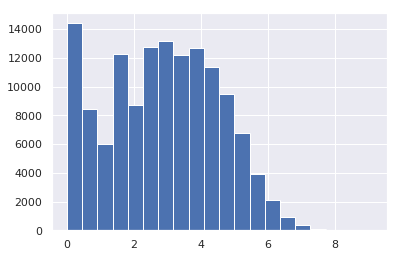

In [0]:
plt.hist(y_train.reshape(-1, 1), bins=20);

При [дискретизации](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer "sklearn.preprocessing.KBinsDiscretizer &#8212; scikit-learn documentation") будем использовать `strategy='quantile'`, чтобы число элементов в интервалах было распределено равномерно.

*Хотя я и не уверен, что это методологически правильно. Так или иначе, в данной задаче у нас более локальная цель: получть в итоге "подсветку" текста от ELI5)*.

## Модель

Токенайзер заранее зафитим отдельно, потому что на обучающем корпусе текстов это длительная операция и её не хотелось бы повторять каждый раз при изменении модели (пока она настраивается)

Параметры [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer "Text Preprocessing - Keras Documentation"), в частности значене `oov_token`, совпадают с теми, которые были использованы при [обучении модели](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw12/nn_hw12_fasttext_model.ipynb "nn_hw12_fasttext_model.ipynb") (это важно для соответствия сохранённым эмбеддингам в первом слое модели).

In [0]:
tokenizer = Tokenizer(num_words=2**20, lower=True, oov_token='епископ')

tokenizer.fit_on_texts(X_train)

with open('nn_hw12_tokenizer.dump', 'wb') as tokenizer_dump:
    pickle.dump(tokenizer, tokenizer_dump)

Адаптируем обученную модели регрессии под задачу классификации и интерфейс [`sklearn estimator`](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#learning-and-predicting "An introduction to machine learning with scikit-learn &#8212; scikit-learn documentation").

Для этого последний слой оригинальной модели регрессии (один нейрон с [линейной активацией](https://keras.io/activations/#linear "Activations - Keras Documentation")) заменим на [Dense](https://keras.io/layers/core/#dense "Core Layers - Keras Documentation") слой с активацией [softmax](https://keras.io/activations/#softmax "Activations - Keras Documentation") и числом нейронов, соответствующим выбранному числу интервалов дискретизации целевой переменной.

Для [дискретизации](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization "5.3. Preprocessing data &#8212; scikit-learn documentation") будет использоваться [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html "sklearn.preprocessing.KBinsDiscretizer &#8212; scikit-learn documentation") из пакета `sklearn`.

In [0]:
def transform_to_classifier(model_path, n_classes):   
    pretrained_model = load_model(model_path)
    
    pretrained_model.layers.pop()
    for layer in pretrained_model.layers:
        layer.trainable=False
    softmax = Dense(units=n_classes, activation='softmax')(pretrained_model.layers[-1].output)
    
    model = Model(inputs=pretrained_model.input, outputs=softmax)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    
    return model

In [0]:
class KerasTextClassifier(BaseEstimator, TransformerMixin):

    def __init__(self, model, fitted_tokenizer, epochs=100, batch_size=256):

        self._model = model
        
        self._tokenizer = fitted_tokenizer
        self._input_length = self._model.input_shape[1]

        self._discretizer = KBinsDiscretizer(n_bins=self._model.layers[-1].output_shape[1],
                                             encode='ordinal', strategy='quantile')

        self._epochs = epochs
        self._batch_size = batch_size

    def _get_sequences(self, texts):
        seqs = self._tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self._input_length, padding='post')

    def fit(self, X, y):
        X_train = self._get_sequences(X)
        y_train = self._discretizer.fit_transform(y.reshape(-1, 1))

        self.history = self._model.fit(X_train, y_train,
                        batch_size=self._batch_size, epochs=self._epochs,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01)])

    def predict_proba(self, X, y=None):
        X_test = self._get_sequences(X)
        return self._model.predict(X_test)

    def predict(self, X, y=None):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y):
        y_test = self._discretizer.transform(y.reshape(-1, 1))
        y_pred = self.predict(X)
        return accuracy_score(y_test, y_pred)

Число интервалов дискретизации *9* подобрано экспериментальным путём. 

Дело в том, что при выборе б*о*льшего числа интервалов и стратегии дискретизации `quantile`, некоторые интервалы становятся слишком маленькими, так что `KBinsDiscretizer` их отбрасывает. Из документации [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer "sklearn.preprocessing.KBinsDiscretizer &#8212; scikit-learn documentation"):

```
Bins whose width are too small (i.e., <= 1e-8) are removed with a warning.

```

В то же время число интервалов мы должны знать заранее, потому что оно определяет число классов и в итоге число нейронов на выходном слое сети.

In [0]:
ktc = KerasTextClassifier(transform_to_classifier('nn_hw12_regressor.h5', n_classes=9),
                          fitted_tokenizer=tokenizer,
                          batch_size=64)

In [0]:
ktc._model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 3000, 300)    314573100   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 3000, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 3000, 128)    187392      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

In [0]:
ktc.fit(X_train, y_train)

ktc._model.save('nn_hw12_classifier.h5')

Train on 122205 samples, validate on 13579 samples
Epoch 1/100
122205/122205 [==============================] - 314s 3ms/step - loss: 1.8293 - acc: 0.2618 - val_loss: 1.7545 - val_acc: 0.2847
Epoch 2/100
122205/122205 [==============================] - 315s 3ms/step - loss: 1.7430 - acc: 0.2906 - val_loss: 1.7059 - val_acc: 0.3002
Epoch 3/100
122205/122205 [==============================] - 315s 3ms/step - loss: 1.7127 - acc: 0.3003 - val_loss: 1.6800 - val_acc: 0.3036
Epoch 4/100
122205/122205 [==============================] - 315s 3ms/step - loss: 1.6972 - acc: 0.3031 - val_loss: 1.6796 - val_acc: 0.3041
Epoch 5/100
122205/122205 [==============================] - 315s 3ms/step - loss: 1.6860 - acc: 0.3079 - val_loss: 1.6550 - val_acc: 0.3136
Epoch 6/100
122205/122205 [==============================] - 315s 3ms/step - loss: 1.6800 - acc: 0.3088 - val_loss: 1.6447 - val_acc: 0.3175
Epoch 7/100
122205/122205 [==============================] - 315s 3ms/step - loss: 1.6738 - acc: 0.3111

In [0]:
def plot_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    def plot_ax(ax, hist, title, train, val, loc='best'):
        last_epoch = len(hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[val])
        
        ax.axvline(x=last_epoch, color='r', linestyle=':')
        bottom, top = ax.get_ylim()
        height = top - bottom
        ymid = bottom + height / 2
        ax.annotate(f'{last_epoch}', xy=(last_epoch, ymid))
        
        val_last = hist[val][last_epoch-1]
        ax.axhline(y=val_last, color='g', linestyle=':')
        left, right = ax.get_xlim()
        y2 = [top - height / 3, bottom + height / 3][bool(val_last < ymid)]
        ax.annotate(f'{val_last:.4f}', xy=(last_epoch, val_last), 
                    xytext=(last_epoch - (last_epoch - left) / 4, y2),
                    size = 14,
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle=f'arc3,rad={.3*[1, -1][bool(val_last < ymid)]:.1f}'))

        ax.set_title(title)
        ax.set_ylabel(train)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(0, last_epoch, 5))
        ax.legend(['train', 'val'], loc=loc)

    plot_ax(ax[0], hist, 'model loss', 'loss', 'val_loss')
    plot_ax(ax[1], hist, 'model accuracy', 'acc', 'val_acc')

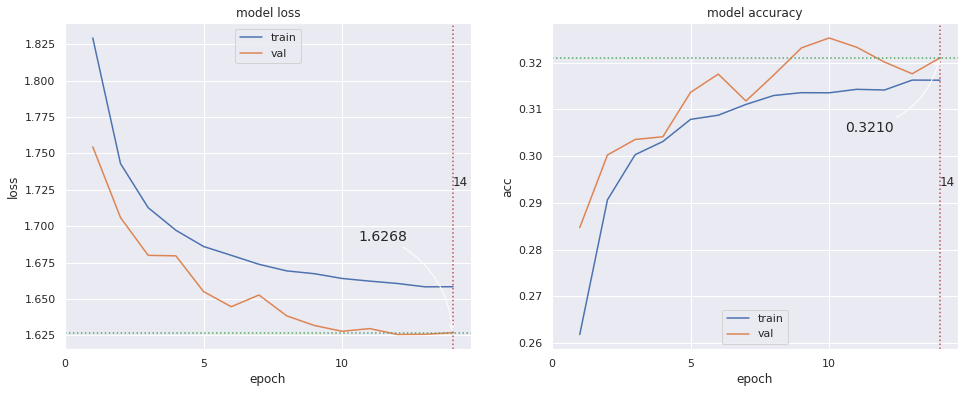

In [0]:
plot_history(ktc.history.history)

In [0]:
ktc.score(X_val, y_val)

0.29590243615046985

Как можно видеть, точность классификации не очень высокая. Возможно, это происходит потому, что задача классификации в данном случае создана искуственно, и границы классов условные. Тем не менее какие-то крайние случаи было бы интересно попробовать интерпретировать c помощью ELI5.

### *Оценка модели*

Распределение по классам для валидационного датасета (с границами классов):

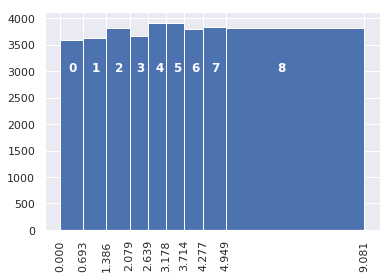

In [0]:
class_labels = list(range(ktc._discretizer.n_bins_[0]))
bin_edges = ktc._discretizer.bin_edges_[0]

plt.hist(y_val.reshape(-1, 1), bins=bin_edges, label=range(9))
plt.xticks(bin_edges, rotation='vertical');

for i in class_labels:
    plt.gca().text(bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2.7, 3000,
                   str(i), color='white', fontweight='bold')

In [0]:
y_val_class = ktc._discretizer.transform(y_val.reshape(-1, 1)).reshape(-1)

y_pred_class = ktc.predict(X_val, y_val)

In [0]:
print(classification_report(y_val_class, y_pred_class, labels=class_labels))

              precision    recall  f1-score   support

           0       0.40      0.72      0.52      3591
           1       0.24      0.14      0.17      3620
           2       0.23      0.25      0.24      3814
           3       0.24      0.09      0.13      3659
           4       0.25      0.10      0.14      3913
           5       0.20      0.36      0.25      3902
           6       0.23      0.20      0.21      3803
           7       0.28      0.27      0.28      3827
           8       0.49      0.55      0.52      3818

    accuracy                           0.30     33947
   macro avg       0.29      0.30      0.27     33947
weighted avg       0.28      0.30      0.27     33947



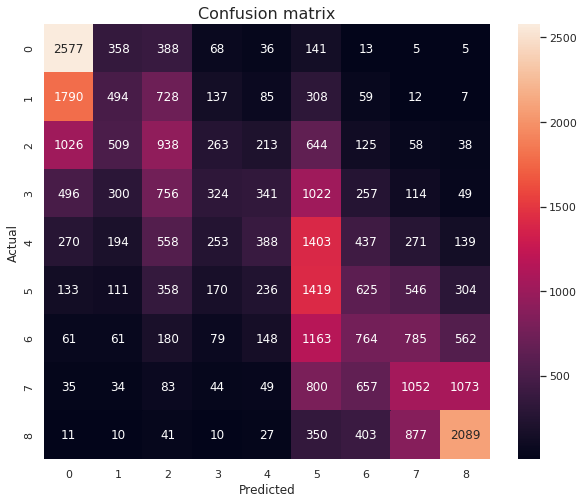

In [0]:
conf_matrix = confusion_matrix(y_val_class, y_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
plt.title('Confusion matrix', fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

In [0]:
del X_train, y_train

## Интерпретация c ELI5

_\* при отображении на **github** слова в текстах ниже не "подсвечиваются"_

In [0]:
def get_sample_doc_ix(y_true, true_class, y_pred, pred_class):
    return np.amin(
        np.argwhere(((y_true == true_class) & (y_pred == pred_class))).squeeze()
    )

### Правильно классифицированный текст

И реальная, и предсказанная оценки -- высокие.

In [0]:
test_doc_ix = get_sample_doc_ix(y_val_class, 8, y_pred_class, 8)

In [0]:
doc = X_val[test_doc_ix]

print(doc[:1024])

Как быстро создать опрос на вашем сайте с помощью форм Google?  Рано или поздно, практически все, у кого есть собственный сайт, сталкиваются с необходимостью создания форм обратной связи для сбора данных (проведения опросов) с посетителей сайта. 
 
Это может быть форма в разделе контакты, через которую посетители сайта будут отправлять вам интересующие их вопросы, может быть форма сбора заявок от клиентов (например, заявки на обратный звонок или заявки на покупку товара), а может быть форма для проведения опроса или голосования по интересующей вас теме. 
 
Есть несколько подходов в создании подобных форм: 
 
• Формы можно сделать, используя теги HTML и завязать нажатие кнопки «Отправить» с отправкой введенных данных вам на email 
 
• Можно сделать связку PHP+MySQL (или любой другой язык программирования и базу данных) и все введенные данные сохранять в базу данных для дальнейшей работы.  
 
• Если ваш сайт сделан с использованием какой-нибудь популярной CMS (например, Joomla, Drupal ил

In [0]:
print(f'[sample #{test_doc_ix}] target value:{y_val[test_doc_ix]:.3f}, actual class: {y_val_class[test_doc_ix]:.0f}, predicted class: {y_pred_class[test_doc_ix]}')

[sample #0] target value:5.971, actual class: 8, predicted class: 8


Как было отмечено, непосредственно использовать `eli5.show_prediction` в нашем случае невозможно, потому что он поддерживает ограниченное число [известных ему библиотек](https://eli5.readthedocs.io/en/latest/libraries/index.html "Supported Libraries &mdash; ELI5 documentation").

In [0]:
eli5.show_prediction(ktc, doc=doc)

Поэтому будем использовать [`TextExplainer`](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html "TextExplainer: debugging black-box text classifiers &mdash; ELI5 documentation") &mdash; реализация алгоритма [LIME](https://homes.cs.washington.edu/~marcotcr/blog/lime/ "LIME - Local Interpretable Model-Agnostic Explanations – Marco Tulio Ribeiro – "), который поддерживает только модели классификации.

In [0]:
te = TextExplainer()

te.fit(doc, ktc.predict_proba)

TextExplainer(char_based=False,
              clf=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.0,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='log',
                                max_iter=1000, n_iter_no_change=5, n_jobs=None,
                                penalty='elasticnet', power_t=0.5,
                                random_state=<mtrand.RandomState object at 0x7fe453655dc8>,
                                shuffle=True,...
                                          weights=array([0.7, 0.3])),
              token_pattern='(?u)\\b\\w+\\b',
              vec=CountVectorizer(analyzer='word', binary=False,
                                  decode_error='strict',
                                  dtype=<class 'numpy.int64'>, encoding='utf-8',
                                  input='content', lowercase=True, ma

In [0]:
te.show_prediction(target_names=class_labels)

### Неправильно классифицированный текст 1

Реальная оценка -- низкая, предсказанная -- высокая

In [0]:
test_doc_ix = get_sample_doc_ix(y_val_class, 0, y_pred_class, 8)

In [0]:
doc = X_val[test_doc_ix]

print(doc[:1024])

Как заработать большие деньги? Повесть одного известного человека. В книге известного предпринимателя, знаменитого уроженца Кубани, удачливого масло — и винодела, академика РААН (Российской Академии Апперцептивных наук), эмигранта, рассказывается о психологической стороне финансовой деятельности, даются оригинальные авторские рецепты успеха. 
 
Содержание 
 
1. Зачем я откровенничаю? 
2. Русские народные поговорки и приметы – вехи народного наблюдения. 
3. Метафизика Вселенной  
4. Методики роста доходов  
5. О добром и злом духе 
______ 
 
1. Зачем я откровенничаю? 
Я уже пожилой человек, добившийся в жизни всего, о чем только можно мечтать. Моих денег мне не прожить до конца моих дней, а учитывая скромность моих потребностей — и за много жизней не прожить. 
Я больше не заинтересован в зарабатывании денег. Будучи евреем, я, за исключением последних лет, жил и работал в России, хорошо узнал страну и её народ, изучил силу и слабости русских. Начав, как беспощадный эксплуататор и иудей, 

In [0]:
print(f'[sample #{test_doc_ix}] target value:{y_val[test_doc_ix]:.3f}, actual class: {y_val_class[test_doc_ix]:.0f}, predicted class: {y_pred_class[test_doc_ix]}')

[sample #1355] target value:0.000, actual class: 0, predicted class: 8


In [0]:
te = TextExplainer()

te.fit(doc, ktc.predict_proba)

te.show_prediction(target_names=class_labels, targets=[0, 8])

### Неправильно классифицированный текст 2

Реальная оценка -- высокая, предсказанная -- низкая.

In [0]:
test_doc_ix = get_sample_doc_ix(y_val_class, 8, y_pred_class, 0)

In [0]:
doc = X_val[test_doc_ix]

print(doc[:1024])

Идеальный соискатель В последние дни на Хабре можно было наблюдать довольно интересные топики о прохождении собеседований и о том, каким же должен быть идеальный соискатель или junior-специалист. И темы эти вызвали значительный ажиотаж среди хабра-сообщества. 
Совершенно случайно, на RSDN, я наткнулся на просто  невероятное по своей силе и глубине высказывание  на эту животрепещущую тему отношений между работодателем и соискателем (автор —  koekto5 ). 
   
Что бывает на типичном интервью? 
— Не знает, чем метод А отличается от метода Б? Да он вообще ничего не умеет. 
— Не помнит, сколько аргументов у какой-то функции? Нет опыта. 
— Не помнит сходу все алгоритмы и структуры данных, которые изучал в университете 15 лет назад? Да чем он вообще занимался? 
— Не знает, почему крышки круглые? Дурак. 
— Нету сертификатов? Мусор. 
— Низкий средний бал? Туп. 
— Смешная фамилия? Придурок. 
— Ищет работу больше двух недель? Лузер. 
— Имеет периоды безработицы по личным причинам? Ненадежен. 
— Вре

In [0]:
print(f'[sample #{test_doc_ix}] target value:{y_val[test_doc_ix]:.3f}, actual class: {y_val_class[test_doc_ix]:.0f}, predicted class: {y_pred_class[test_doc_ix]}')

[sample #4808] target value:4.997, actual class: 8, predicted class: 0


In [0]:
te = TextExplainer()

te.fit(doc, ktc.predict_proba)

te.show_prediction(target_names=class_labels, targets=[0, 8])

### Выводы

Думаю, что к текстам можно было бы применить следующую дополнительную предобработку, чтобы улучшить качество модели:

* Удалить числа, либо заменить их на какой-то текст (`"число"` ?)
* Добавить в список стоп-слов предлоги, частицы (`"не"` и т.п.) и другие вспомогательные части речи.

*А если говорить в целом, то думаю, что популярность статьи не всегда зависит только от её содержания, т.е. непосредственно от текста, тут важен также и контекст: личность автора, дата выхода статьи, общая популярность некоторой тематики в это время и т.д. Так что в рамках данной задачи ожидать какой-то сверхвысокой точности, думаю, и не следует*.

---

####\*___Update___: _Cтоп-слова_

В задании было предложено _"добавить стоп-слова в модель"_ что, очевидно, предполагает обучение новой модели с целью сравнить изменение качества предсказания с оригинальной.

Тем не менее, несколько причин в совокупности обусловили мой отказ от попытки обучить новую модель. Главным образом, дело в том, что на данную учебную задачу и так ушло достаточно много времени и усилий, и уже, к сожалению, нет возможности вкладывать дополнительные ресурсы для создания качественного решения с использованием "стоп-слов". Помимо очевидной причины, что модель сама по себе обучается довольно длительное время, существуют также определённые сложности с использованием "стоп-слов" при векторизации текста, которые коротко рассматриваются ниже.

Итак, далее некоторые факты и соображения насчёт подхода с использованием "стоп-слов" в контексте данной задачи:

1.   В оригинальной задаче для токенизации использовался [Keras Tokenizer](https://keras.io/preprocessing/text/#tokenizer "Text Preprocessing - Keras Documentation"), который представляет собой достаточно простой инструмент, где отсутствует встроенная поддержка "стоп-слов".То есть непосредственно его использовать для этой цели не получится, и этап токенизации придётся переделывать.
2.   Можно было бы использовать [встроенный препроцессор](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.build_preprocessor "sklearn.feature_extraction.text.CountVectorizer &#8212; scikit-learn documentation") класса [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html "sklearn.feature_extraction.text.CountVectorizer &#8212; scikit-learn documentation") из [`sklearn`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text "API Reference &#8212; scikit-learn documentation"). Там есть поддержка "стоп-слов" (параметр `stop_words` конструктора `CountVectorizer`). Однако там пока есть встроенная поддержка только для английского языка (либо можно передавать кастомный список слов). При этом разработчики [признают](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words "5.2. Feature extraction &mdash; scikit-learn documentation"), что со встроенным списком `english` есть проблемы:
> There are several known issues with ‘english’ and you should consider an alternative (see [Using stop words](https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words "5.2. Feature extraction &mdash; scikit-learn documentation")).
3.   Для "стоп-слов" можно использовать библиотеку [nltk](https://www.nltk.org/ "Natural Language Toolkit &#8212; NLTK documentation"). Однако это уже больше тема следующего модуля курса: [Анализ текстов](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/09-NLP/01-preprocessing/texts_sem1.ipynb "hse-cs-ml-2018-2019/texts_sem1.ipynb at master · rklepov/hse-cs-ml-2018-2019").
4.   Замена чисел на слова (`"число"` и т.п.) не очень поможет, так как статьи всё-таки свободного характера.
5.   До получения эмбеддингов еще полезно провести [лемматизацию](https://pymorphy2.readthedocs.io/en/latest/ "Морфологический анализатор pymorphy2 &mdash; Морфологический анализатор pymorphy2") или [стемминг](http://www.nltk.org/howto/stem.html "nltk.stem package &#8212; NLTK documentation").
*Тут ещё интересный момент, что у [**DeepPavlov**](http://docs.deeppavlov.ai/en/master/index.html "Welcome to DeepPavlov’s documentation! &mdash; DeepPavlov documentation") есть разные варианты эмбеддингов [**fastText**](http://docs.deeppavlov.ai/en/master/features/pretrained_vectors.html#id4 "Pre-trained embeddings &mdash; DeepPavlov 0.6.0 documentation"), обученные на одном и том же корпусе текстов. В данной задаче я использовал [`ft_native_300_ru_wiki_lenta_lemmatize.vec`](http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_lemmatize/ft_native_300_ru_wiki_lenta_lemmatize.vec), который описан как:*
> Wiki+Lenta | tokenize (nltk word_tokenize), lemmatize (pymorphy2)

*Но, возможно, следовало бы использовать как раз варианты без лемматизации (поскольку к исходым текстам лемматизация не применялась)? Хотя, с другой стороны, они больше по объёму, а у меня и так были проблемы с нехваткой RAM в процессе подготовки данных для модели и её обучения.*

---

### _References_

[1] [Overview &mdash; ELI5 0.8.2 documentation](https://eli5.readthedocs.io/en/latest/overview.html "Overview &mdash; ELI5 0.8.2 documentation")

[2] [Debugging scikit-learn text classification pipeline &mdash; ELI5 0.8.2 documentation](https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html "Debugging scikit-learn text classification pipeline &mdash; ELI5 0.8.2 documentation")

[3] [ELI5: which features are important for price prediction](https://www.kaggle.com/lopuhin/eli5-for-mercari "ELI5 for Mercari | Kaggle")

[4] [LIME - Local Interpretable Model-Agnostic Explanations](https://homes.cs.washington.edu/~marcotcr/blog/lime/ "LIME - Local Interpretable Model-Agnostic Explanations – Marco Tulio Ribeiro – ")

[5] [scikit-learn User Guide / 5. Dataset transformations / 5.2. Feature extraction / 5.2.3. Text feature extraction / 5.2.3.3. Common Vectorizer usage](https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage "5.2. Feature extraction &mdash; scikit-learn documentation")

[6] [scikit-learn User Guide / 5. Dataset transformations / 5.3. Preprocessing data / 5.3.5. Discretization / 5.3.5.1. K-bins discretization](https://scikit-learn.org/stable/modules/preprocessing.html#k-bins-discretization "5.3. Preprocessing data &#8212; scikit-learn documentation")